In [8]:
# !pip install ultralytics

Run this cell as it is

In [ ]:
import os
import glob
import yaml
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

class_name = { 0: 'Mass',
1: 'Spiculation',
2: 'Suspicious Calcification',
3: 'Architectural Distortion',
4: 'Asymmetry',
5: 'Focal Asymmetry',
6: 'Skin Thickening',
7: 'Global Asymmetry',
8: 'Suspicious Lymph Node',
9: 'Skin Retraction',
10: 'Nipple Retraction'
}

color_dict = {
    0: (255, 0, 0),      # Red
    1: (0, 255, 0),      # Green
    2: (0, 0, 255),      # Blue
    3: (255, 255, 0),    # Yellow
    4: (255, 165, 0),    # Orange
    5: (128, 0, 128),    # Purple
    6: (0, 255, 255),    # Cyan
    7: (255, 192, 203),  # Pink
    8: (128, 128, 0),    # Olive
    9: (0, 0, 0),        # Black
    10: (169, 169, 169)  # Dark Grey
}

Run this cell as it is

In [10]:
def remove_cache_files(directory):
    cache_files = glob.glob(os.path.join(directory, "*.cache"))
    for cache_file in cache_files:
        os.remove(cache_file)
        print(f"Removed: {cache_file}")
        
with open("/home/rshah133/bcd/dataset.yaml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)

remove_cache_files(os.path.dirname(data_loaded['train']))
remove_cache_files(os.path.dirname(data_loaded['val']))

Model Setup, Change the model and hyperparameters. Keep epochs atleast 50

In [11]:
model = YOLO('yolov8n.yaml')
results = model.train(data = "/home/rshah133/bcd/dataset.yaml", epochs = 300, imgsz = 640, batch = 6, device = 0, patience = 20)

New https://pypi.org/project/ultralytics/8.3.63 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.58 🚀 Python-3.11.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-80GB, 81158MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/home/rshah133/bcd/dataset.yaml, epochs=300, time=None, patience=20, batch=6, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fals

train: Scanning /home/rshah133/breast_cancer_detection/train_val_birads5_test_birads5/train/labels... 112 images, 0 backgrounds, 0 corrupt: 100%|██████████| 112/112 [00:00<00:00, 1777.84it/s]

train: New cache created: /home/rshah133/breast_cancer_detection/train_val_birads5_test_birads5/train/labels.cache



/home/rshah133/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val: Scanning /home/rshah133/breast_cancer_detection/train_val_birads5_test_birads5/val/labels... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<00:00, 932.48it/s]

val: New cache created: /home/rshah133/breast_cancer_detection/train_val_birads5_test_birads5/val/labels.cache



/home/rshah133/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000515625), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300     0.986G      4.541      5.714      4.195         34        640: 100%|██████████| 19/19 [00:02<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.99it/s]

                   all         21        140          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300     0.912G        4.6      5.609      4.197         51        640: 100%|██████████| 19/19 [00:01<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.91it/s]

                   all         21        140          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300     0.954G       4.73       5.47      4.133         61        640: 100%|██████████| 19/19 [00:01<00:00, 14.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.88it/s]

                   all         21        140          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300     0.967G      4.349       5.17      4.084         27        640: 100%|██████████| 19/19 [00:01<00:00, 15.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.62it/s]

                   all         21        140          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300     0.986G      4.517       5.21      4.017         51        640: 100%|██████████| 19/19 [00:01<00:00, 16.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.71it/s]

                   all         21        140          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300     0.984G      4.071      4.835      3.987         45        640: 100%|██████████| 19/19 [00:01<00:00, 16.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 24.27it/s]

                   all         21        140          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300     0.954G      4.151      4.689      3.903         48        640: 100%|██████████| 19/19 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.47it/s]

                   all         21        140   0.000428     0.0237   0.000244   8.32e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300     0.963G       3.98       4.52      3.821         32        640: 100%|██████████| 19/19 [00:01<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.36it/s]

                   all         21        140      0.286     0.0136    0.00675    0.00209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      0.94G      4.005      4.416      3.812         62        640: 100%|██████████| 19/19 [00:01<00:00, 11.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.03it/s]

                   all         21        140      0.573     0.0068    0.00166   0.000358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300     0.923G      3.848      4.366      3.767         21        640: 100%|██████████| 19/19 [00:02<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.01it/s]

                   all         21        140      0.859     0.0068   0.000824   0.000154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300     0.967G      3.874      4.248      3.662         48        640: 100%|██████████| 19/19 [00:03<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.50it/s]

                   all         21        140      0.145     0.0118   0.000891    0.00041



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300     0.954G      3.845      4.292      3.583         48        640: 100%|██████████| 19/19 [00:01<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.79it/s]

                   all         21        140       0.15     0.0068    0.00378    0.00218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300     0.954G      3.779      4.021      3.554         50        640: 100%|██████████| 19/19 [00:01<00:00, 14.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.03it/s]


                   all         21        140      0.433     0.0068    0.00278   0.000989

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300     0.984G      3.794      4.128      3.459         41        640: 100%|██████████| 19/19 [00:02<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

                   all         21        140      0.145     0.0498    0.00644    0.00151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300     0.967G      3.728       3.91      3.367         56        640: 100%|██████████| 19/19 [00:02<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         21        140      0.149     0.0379    0.00455      0.001



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300     0.952G      3.717      3.924      3.341         36        640: 100%|██████████| 19/19 [00:01<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]

                   all         21        140    0.00234     0.0368    0.00347   0.000661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300     0.954G      3.631      3.816      3.258         36        640: 100%|██████████| 19/19 [00:02<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         21        140     0.0027     0.0498    0.00386   0.000679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300     0.969G      3.732      3.912      3.259         31        640: 100%|██████████| 19/19 [00:01<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.59it/s]

                   all         21        140      0.288     0.0594    0.00341   0.000487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300     0.969G      3.751      3.858      3.197         20        640: 100%|██████████| 19/19 [00:02<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]

                   all         21        140    0.00273      0.105    0.00326   0.000791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300     0.971G      3.648       3.91      3.196         40        640: 100%|██████████| 19/19 [00:01<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

                   all         21        140    0.00303      0.114    0.00728    0.00145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300     0.923G      3.694       3.82      3.145         41        640: 100%|██████████| 19/19 [00:02<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 20.18it/s]

                   all         21        140    0.00238      0.127    0.00449    0.00122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300     0.971G      3.652        3.7      3.137         42        640: 100%|██████████| 19/19 [00:02<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         21        140    0.00264      0.131    0.00738    0.00175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300     0.967G      3.716      3.691      3.061         12        640: 100%|██████████| 19/19 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

                   all         21        140    0.00276      0.103    0.00565    0.00181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300     0.973G      3.639      3.472      3.047         65        640: 100%|██████████| 19/19 [00:01<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.49it/s]


                   all         21        140    0.00231      0.102    0.00653    0.00143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300     0.975G      3.645      3.722      3.038         33        640: 100%|██████████| 19/19 [00:02<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.48it/s]

                   all         21        140    0.00245     0.0999    0.00494    0.00108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300     0.954G      3.672       3.69       3.02         38        640: 100%|██████████| 19/19 [00:02<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

                   all         21        140    0.00284      0.119    0.00317      0.001



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300     0.977G      3.594      3.615      2.978         44        640: 100%|██████████| 19/19 [00:01<00:00, 13.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


                   all         21        140      0.154     0.0203    0.00742    0.00159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300     0.971G      3.704      3.655       2.99         24        640: 100%|██████████| 19/19 [00:01<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.34it/s]

                   all         21        140     0.0765     0.0343     0.0145    0.00257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300     0.963G      3.583      3.575      2.946         44        640: 100%|██████████| 19/19 [00:02<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]

                   all         21        140    0.00458     0.0982     0.0108    0.00252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300     0.971G      3.615      3.416      2.903         63        640: 100%|██████████| 19/19 [00:02<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         21        140     0.0102     0.0886      0.013    0.00343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300     0.954G      3.618      3.484      2.881         31        640: 100%|██████████| 19/19 [00:02<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         21        140    0.00597      0.084    0.00878    0.00282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300     0.923G      3.561      3.501      2.974         53        640: 100%|██████████| 19/19 [00:01<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.44it/s]

                   all         21        140    0.00248      0.111    0.00696    0.00198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300     0.977G      3.579      3.524      2.924         18        640: 100%|██████████| 19/19 [00:01<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]

                   all         21        140    0.00732      0.058    0.00595    0.00152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300     0.973G      3.592      3.526      2.909         41        640: 100%|██████████| 19/19 [00:02<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.55it/s]

                   all         21        140      0.155     0.0118     0.0075    0.00203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300     0.975G      3.547      3.527      2.929         29        640: 100%|██████████| 19/19 [00:01<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.66it/s]

                   all         21        140     0.0117     0.0135      0.013     0.0033



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300     0.981G      3.615      3.599      2.867         29        640: 100%|██████████| 19/19 [00:02<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.65it/s]

                   all         21        140    0.00387      0.108    0.00935    0.00267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300     0.975G      3.525      3.511      2.874         64        640: 100%|██████████| 19/19 [00:02<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.53it/s]

                   all         21        140      0.298     0.0068    0.00406    0.00114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300     0.946G       3.51       3.54      2.811         32        640: 100%|██████████| 19/19 [00:02<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]

                   all         21        140    0.00628     0.0512     0.0059    0.00113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300     0.971G      3.451      3.239      2.831         38        640: 100%|██████████| 19/19 [00:02<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         21        140     0.0163     0.0386    0.00536    0.00134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300     0.969G      3.495      3.531       2.83         55        640: 100%|██████████| 19/19 [00:02<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         21        140     0.0193     0.0192    0.00508    0.00124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300     0.975G      3.499      3.384      2.912         48        640: 100%|██████████| 19/19 [00:02<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         21        140     0.0149     0.0203     0.0144    0.00438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300     0.954G      3.488      3.356      2.764         52        640: 100%|██████████| 19/19 [00:01<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.11it/s]

                   all         21        140     0.0337     0.0206     0.0116    0.00351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300     0.931G      3.459      3.482      2.757         31        640: 100%|██████████| 19/19 [00:02<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]

                   all         21        140     0.0442     0.0283     0.0137    0.00533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300     0.971G      3.528      3.516       2.71         41        640: 100%|██████████| 19/19 [00:02<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.64it/s]

                   all         21        140    0.00226     0.0855    0.00305    0.00107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300     0.954G      3.393      3.316      2.766         56        640: 100%|██████████| 19/19 [00:02<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.48it/s]

                   all         21        140    0.00809     0.0623    0.00649    0.00192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300     0.971G      3.412      3.227      2.697         53        640: 100%|██████████| 19/19 [00:02<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.47it/s]

                   all         21        140      0.292      0.153    0.00733    0.00198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300     0.954G      3.381      3.373      2.727         57        640: 100%|██████████| 19/19 [00:02<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         21        140     0.0165     0.0199    0.00853    0.00223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300     0.963G      3.292      3.171      2.706         36        640: 100%|██████████| 19/19 [00:02<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         21        140      0.326     0.0385     0.0262     0.0096



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      0.95G      3.328      3.327      2.806         29        640: 100%|██████████| 19/19 [00:02<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

                   all         21        140      0.325     0.0431      0.021    0.00598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300     0.954G      3.372      3.376      2.723         17        640: 100%|██████████| 19/19 [00:01<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]

                   all         21        140      0.319      0.042     0.0239    0.00604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300     0.975G       3.39      3.195      2.725         50        640: 100%|██████████| 19/19 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 25.56it/s]

                   all         21        140      0.318     0.0339     0.0209    0.00562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300     0.973G      3.364      3.363      2.719         26        640: 100%|██████████| 19/19 [00:01<00:00, 16.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.86it/s]

                   all         21        140     0.0403     0.0393     0.0169    0.00476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300     0.954G      3.273      3.213       2.73         45        640: 100%|██████████| 19/19 [00:01<00:00, 14.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.48it/s]

                   all         21        140     0.0424     0.0183     0.0134    0.00407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300     0.944G      3.292      3.131      2.725         26        640: 100%|██████████| 19/19 [00:01<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 22.13it/s]

                   all         21        140     0.0399     0.0397      0.019    0.00564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300     0.967G      3.244      3.148      2.672         41        640: 100%|██████████| 19/19 [00:01<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.27it/s]

                   all         21        140      0.185     0.0397     0.0217    0.00655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300     0.971G      3.224       3.17      2.732         25        640: 100%|██████████| 19/19 [00:04<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.66it/s]


                   all         21        140      0.201     0.0692     0.0295    0.00888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300     0.954G      3.224       3.04       2.63         31        640: 100%|██████████| 19/19 [00:01<00:00, 14.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.90it/s]

                   all         21        140      0.343     0.0591     0.0299    0.00751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300     0.971G      3.228      3.053      2.576         54        640: 100%|██████████| 19/19 [00:01<00:00, 15.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 25.33it/s]

                   all         21        140     0.0638     0.0635     0.0248    0.00698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300     0.971G      3.219      3.038      2.582         53        640: 100%|██████████| 19/19 [00:01<00:00, 14.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 23.47it/s]

                   all         21        140      0.487     0.0408     0.0214    0.00689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300     0.967G      3.289      3.093      2.694         47        640: 100%|██████████| 19/19 [00:01<00:00, 15.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 20.63it/s]

                   all         21        140      0.349     0.0323     0.0278    0.00826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300     0.973G      3.172      3.075      2.569         21        640: 100%|██████████| 19/19 [00:00<00:00, 19.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.84it/s]

                   all         21        140      0.335     0.0346     0.0294    0.00752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300     0.967G      3.243      3.155      2.675         53        640: 100%|██████████| 19/19 [00:01<00:00, 16.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.02it/s]

                   all         21        140        0.5     0.0539     0.0316    0.00803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300     0.975G      3.164      3.042      2.572         62        640: 100%|██████████| 19/19 [00:01<00:00, 16.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.03it/s]

                   all         21        140     0.0785     0.0557     0.0272    0.00782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300     0.973G      3.143      3.162      2.561         39        640: 100%|██████████| 19/19 [00:01<00:00, 15.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 23.16it/s]

                   all         21        140      0.493     0.0552     0.0262    0.00711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300     0.923G       3.14      3.132      2.617         41        640: 100%|██████████| 19/19 [00:01<00:00, 14.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 22.91it/s]

                   all         21        140      0.463     0.0352     0.0169    0.00483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300     0.967G      3.128      2.995      2.562         43        640: 100%|██████████| 19/19 [00:01<00:00, 16.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.53it/s]

                   all         21        140      0.339     0.0506     0.0287    0.00907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300     0.973G      3.136      3.029      2.644         39        640: 100%|██████████| 19/19 [00:01<00:00, 15.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.41it/s]

                   all         21        140     0.0538     0.0311     0.0175    0.00463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300     0.975G      3.161       3.09        2.6         26        640: 100%|██████████| 19/19 [00:01<00:00, 14.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.88it/s]

                   all         21        140     0.0333     0.0175    0.00623    0.00159
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 48, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



68 epochs completed in 0.055 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-80GB, 81158MiB)
YOLOv8n summary (fused): 168 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.65it/s]


                   all         21        140      0.328     0.0415     0.0264    0.00957
                  Mass         18         25      0.197      0.196      0.148     0.0582
           Spiculation         21         85     0.0757     0.0471     0.0191    0.00361
Suspicious Calcification         14         21     0.0205     0.0476     0.0179     0.0052
       Skin Thickening          1          1          1          0          0          0
      Global Asymmetry          1          1          1          0          0          0
 Suspicious Lymph Node          6          6          0          0          0          0
       Skin Retraction          1          1          0          0          0          0
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train


Run this cell as it is

In [12]:
with open("/home/rshah133/bcd/test_dataset.yaml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)

remove_cache_files(os.path.dirname(data_loaded['train']))
remove_cache_files(os.path.dirname(data_loaded['val']))

Removed: /home/rshah133/breast_cancer_detection/train_val_birads5_test_birads5/test/labels.cache


## Change path and mention the latest train folder generated

* For eg. '/home/rshah133/bcd/runs/detect/train/weights/best.pt'
* I have train as the latest file. Next time I run the code it would change to train2. 
* So please check and change this everytime you run the code

In [13]:
best_model_path = 'runs/detect/train/weights/best.pt'

Predicting on test data

In [14]:
best_model = YOLO(best_model_path)

test_img_path = data_loaded['val']
results = best_model.predict(source = test_img_path, save = True,  save_txt = True,  conf = 0.1)


image 1/24 /home/rshah133/breast_cancer_detection/train_val_birads5_test_birads5/test/images/1560345de7d8277b170ca3842eae6c97_e751e5a947089704457741eea74c2280.jpg: 640x512 (no detections), 31.5ms
image 2/24 /home/rshah133/breast_cancer_detection/train_val_birads5_test_birads5/test/images/21ee099d74242fca1551adb6f2564a15_b73d4e04b69d52ba6f350cc77da54f95.jpg: 640x512 1 Mass, 3 Spiculations, 2 Suspicious Calcifications, 5.5ms
image 3/24 /home/rshah133/breast_cancer_detection/train_val_birads5_test_birads5/test/images/2dfe6025d5954c2925d6288b50dccbea_a20301f2d2cafec6419d759fa7c70c0b.jpg: 640x480 1 Mass, 5 Spiculations, 1 Suspicious Calcification, 27.6ms
image 4/24 /home/rshah133/breast_cancer_detection/train_val_birads5_test_birads5/test/images/3b9d3e9aa2fcdefd74d4cbfb496694b4_6c571a3fb5a3abe21141333f65b5bf09.jpg: 640x512 2 Spiculations, 1 Suspicious Calcification, 6.0ms
image 5/24 /home/rshah133/breast_cancer_detection/train_val_birads5_test_birads5/test/images/43a5db0fd868e525cf75aaf5d5

Run this cell as it is and take screenshot of the output. This code is for calculating the metrics for test data

In [15]:
metrics = best_model.val(data = '/home/rshah133/bcd/test_dataset.yaml', conf = 0.15)

Ultralytics 8.3.58 🚀 Python-3.11.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-80GB, 81158MiB)


val: Scanning /home/rshah133/breast_cancer_detection/train_val_birads5_test_birads5/test/labels... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<00:00, 1705.23it/s]

val: New cache created: /home/rshah133/breast_cancer_detection/train_val_birads5_test_birads5/test/labels.cache



/home/rshah133/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


                   all         24        148     0.0809     0.0472     0.0625     0.0225
                  Mass         15         17      0.308      0.235      0.295      0.137
           Spiculation         24         86       0.32      0.093      0.203     0.0357
Suspicious Calcification         20         31        0.1     0.0968     0.0643     0.0295
Architectural Distortion          1          1          0          0          0          0
       Skin Thickening          1          1          0          0          0          0
      Global Asymmetry          1          1          0          0          0          0
 Suspicious Lymph Node          7          8          0          0          0          0
       Skin Retraction          1          1          0          0          0          0
     Nipple Retraction          2          2          0          0          0          0
Speed: 0.1ms preprocess, 8.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/de

## Change the directory of the variable below

* predictions_dir = Directory for the predicted labels. Eg:- "runs/detect/predict/labels" 
* Here predict is variable and can change to predict2, predict3 etc everytime you run it. So change it everytime

In [16]:
predictions_dir = "runs/detect/predict/labels"   

Run this cell as it is

In [17]:
test_images_dir = data_loaded['val']
test_labels_dir = os.path.join(os.path.dirname(data_loaded['val']), 'labels')


output_labels_dir = "results/labels"  # Directory to save ground truth images
output_pred_dir = "results/predictions"  # Directory to save predicted images

# Create output directory if it doesn't exist
os.makedirs(output_labels_dir, exist_ok=True)
os.makedirs(output_pred_dir, exist_ok=True)

# Function to read YOLO format labels
def read_yolo_labels(label_file):
    labels = []
    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            class_id, x_center, y_center, width, height = map(float, parts[:5])
            confidence = float(parts[5]) if len(parts) > 5 else None
            labels.append((int(class_id), x_center, y_center, width, height, confidence))
    return labels

# Function to draw bounding boxes on images
def draw_boxes(image, boxes):
    h, w, _ = image.shape
    for box in boxes:
        class_id, x_center, y_center, width, height, confidence = box
        x_min = int((x_center - width / 2) * w)
        y_min = int((y_center - height / 2) * h)
        x_max = int((x_center + width / 2) * w)
        y_max = int((y_center + height / 2) * h)
        # Draw rectangle
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color_dict[class_id], 2)
    return image

# Loop through each image
for image_file in os.listdir(test_images_dir):
    if image_file.endswith((".jpg", ".png", ".jpeg")):
        base_name = os.path.splitext(image_file)[0]
        image_path = os.path.join(test_images_dir, image_file)

        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error loading {image_file}")
            continue

        # Read ground truth labels
        ground_truth_file = os.path.join(test_labels_dir, f"{base_name}.txt")
        ground_truth_boxes = read_yolo_labels(ground_truth_file) if os.path.exists(ground_truth_file) else []

        # Read prediction labels
        prediction_file = os.path.join(predictions_dir, f"{base_name}.txt")
        prediction_boxes = read_yolo_labels(prediction_file) if os.path.exists(prediction_file) else []

        # Draw ground truth (green) and predictions (blue)
        image_with_boxes_gt = draw_boxes(image.copy(), ground_truth_boxes)
        image_with_boxes_pt = draw_boxes(image.copy(), prediction_boxes)

        # Save annotated image
        gt_output_path = os.path.join(output_labels_dir, image_file)
        cv2.imwrite(gt_output_path, image_with_boxes_gt)

        pt_output_path = os.path.join(output_pred_dir, image_file)
        cv2.imwrite(pt_output_path, image_with_boxes_pt)

print("Done saving the predictions")

Done saving the predictions


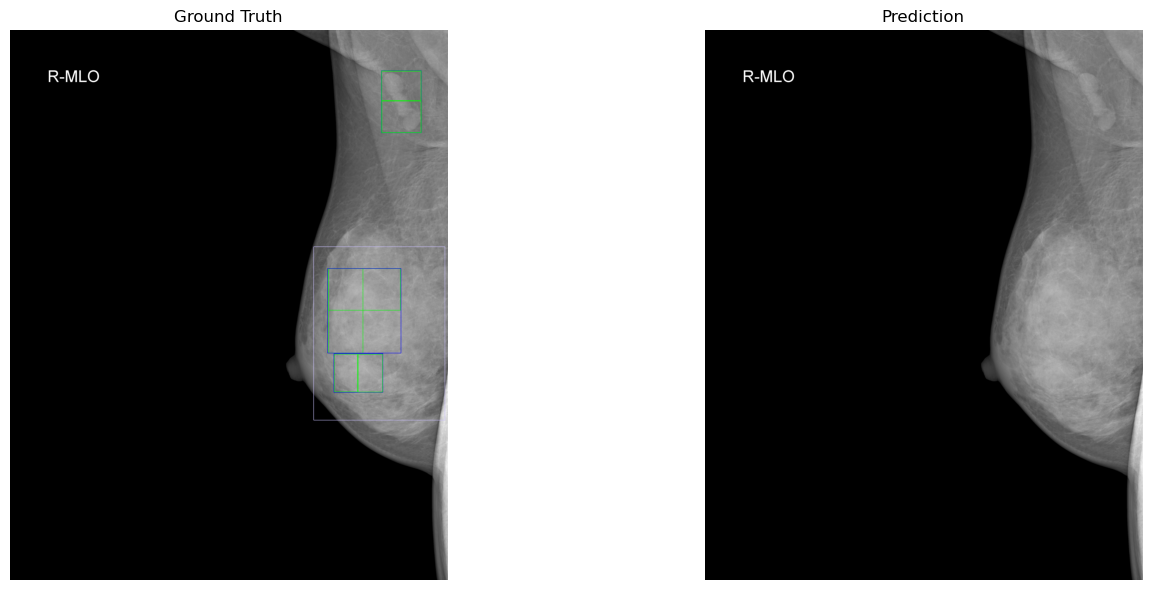

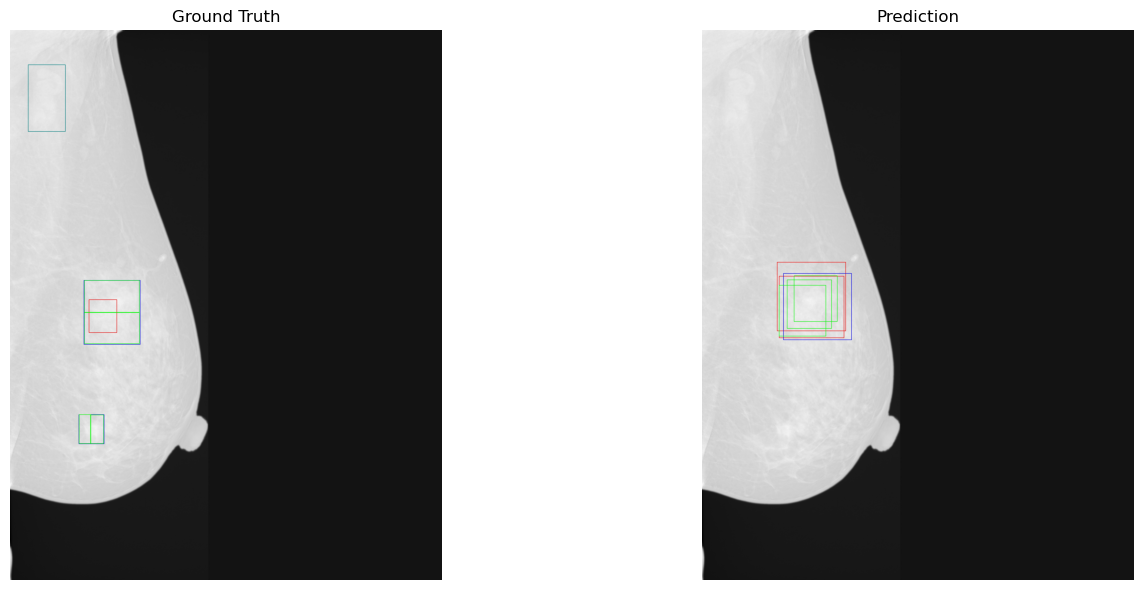

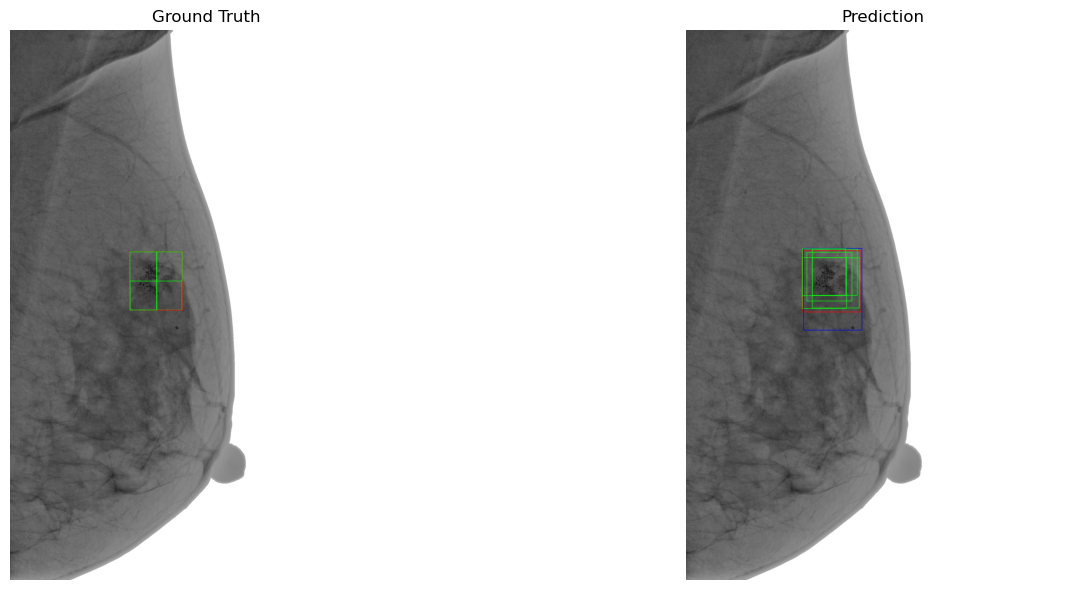

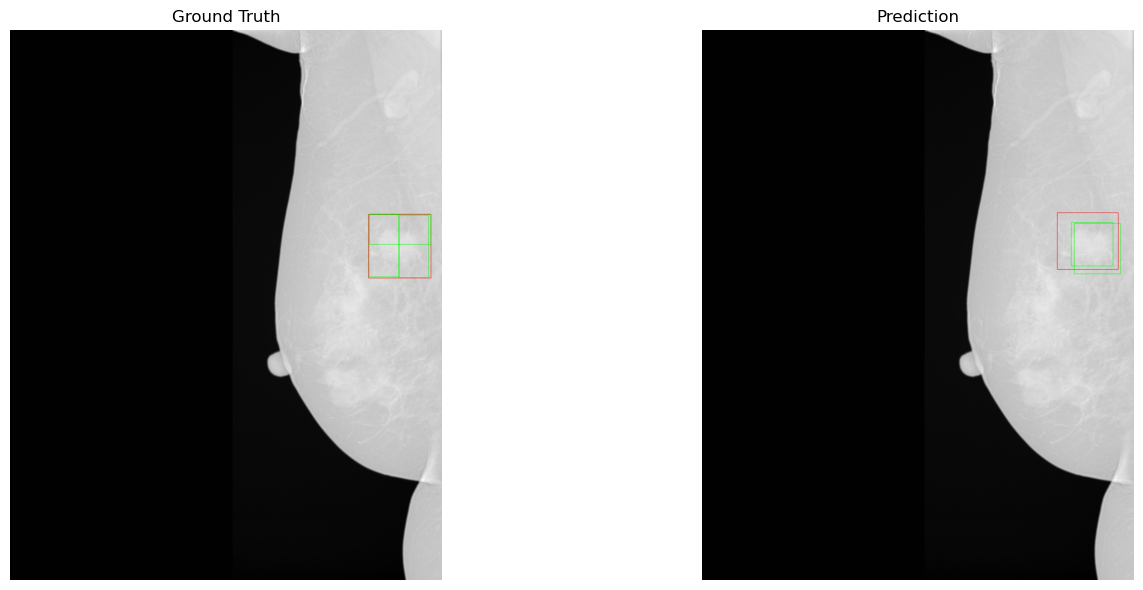

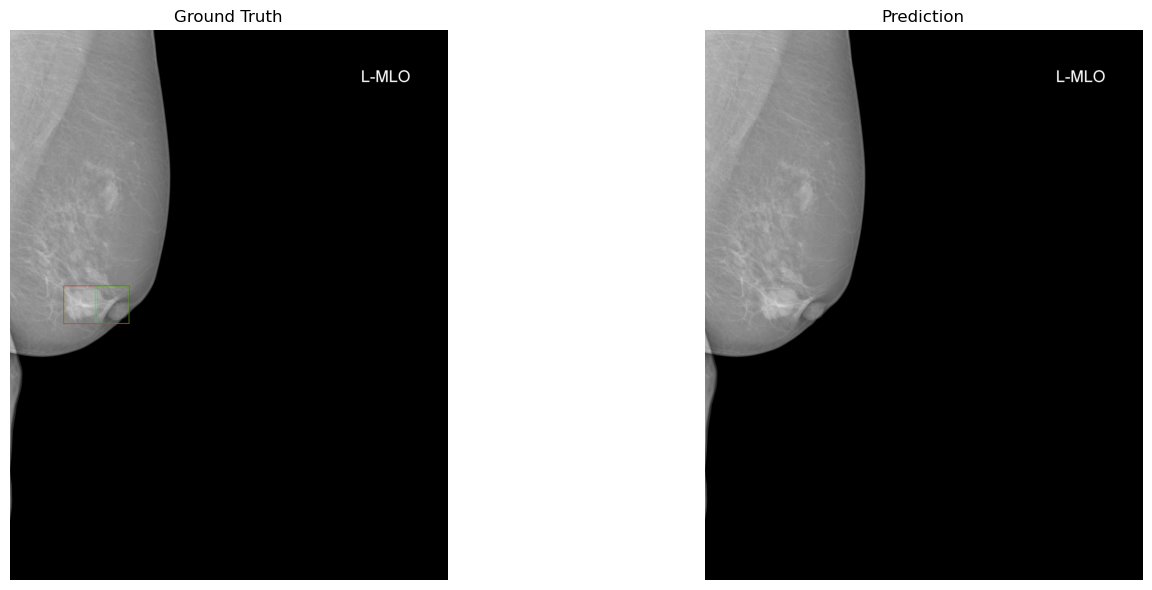

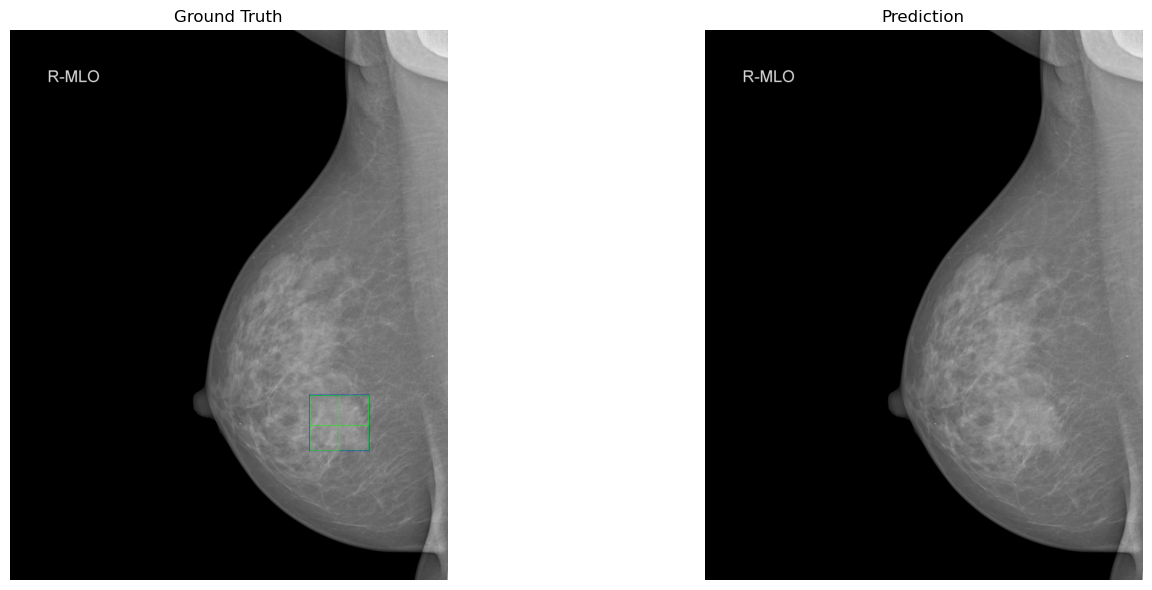

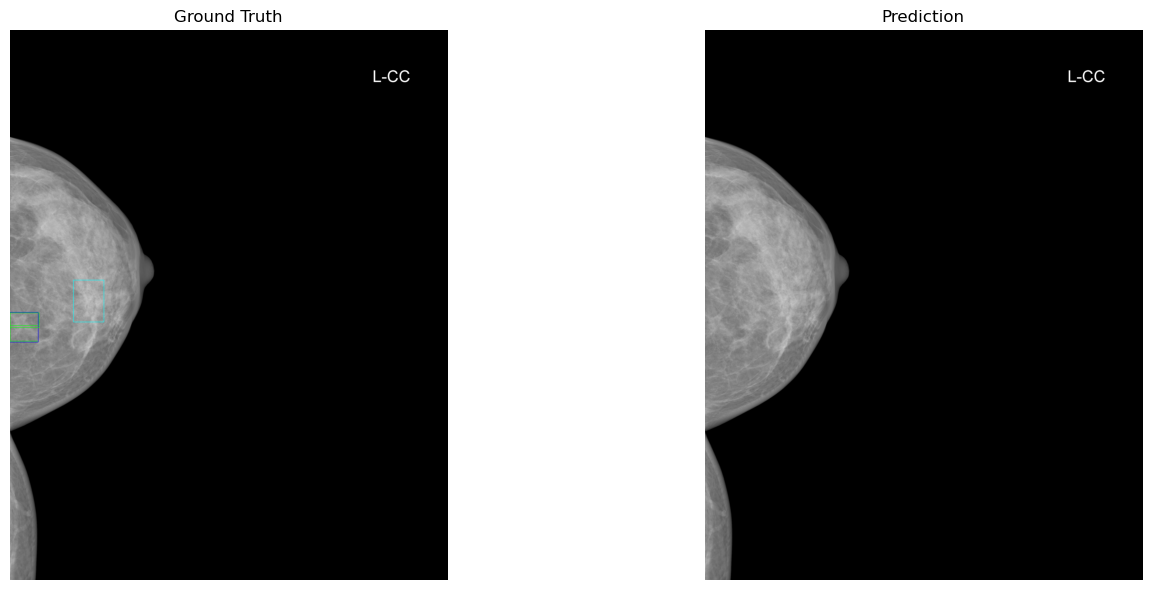

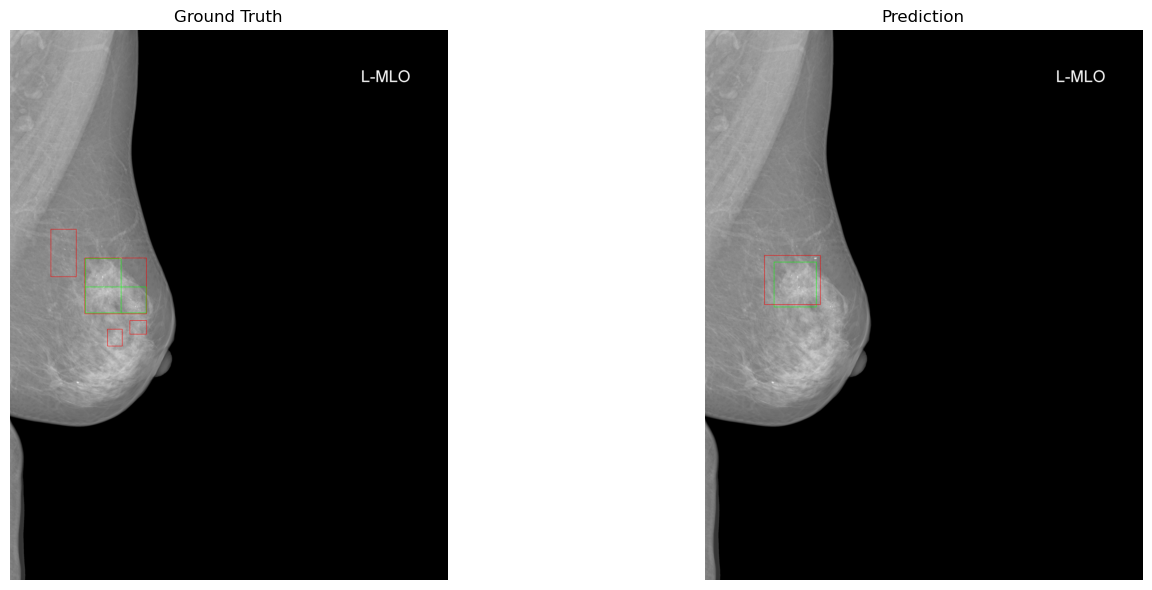

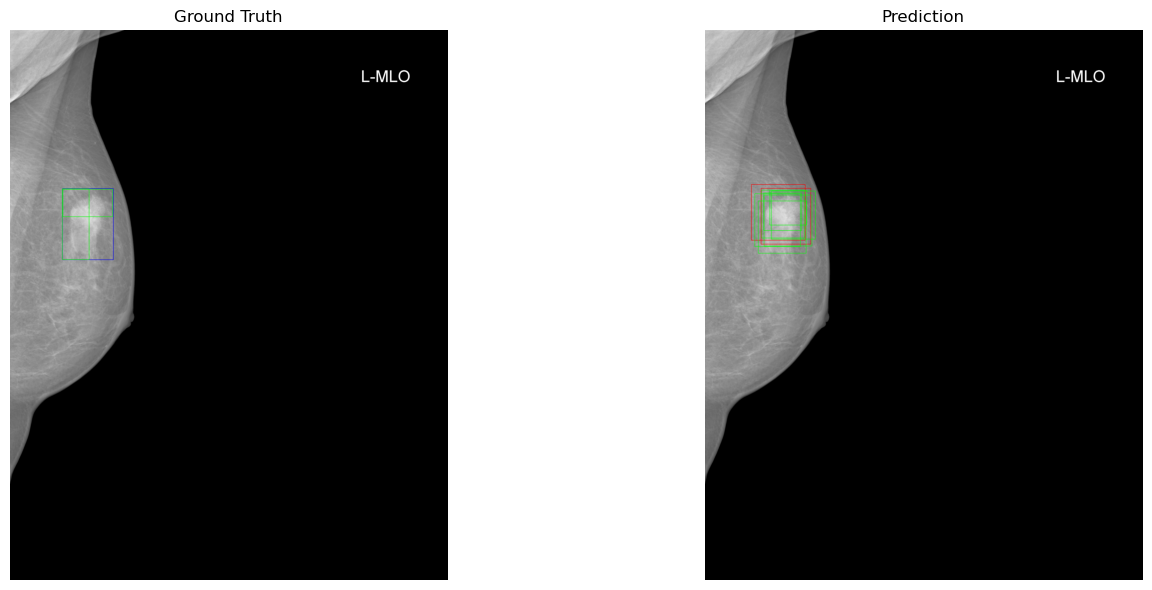

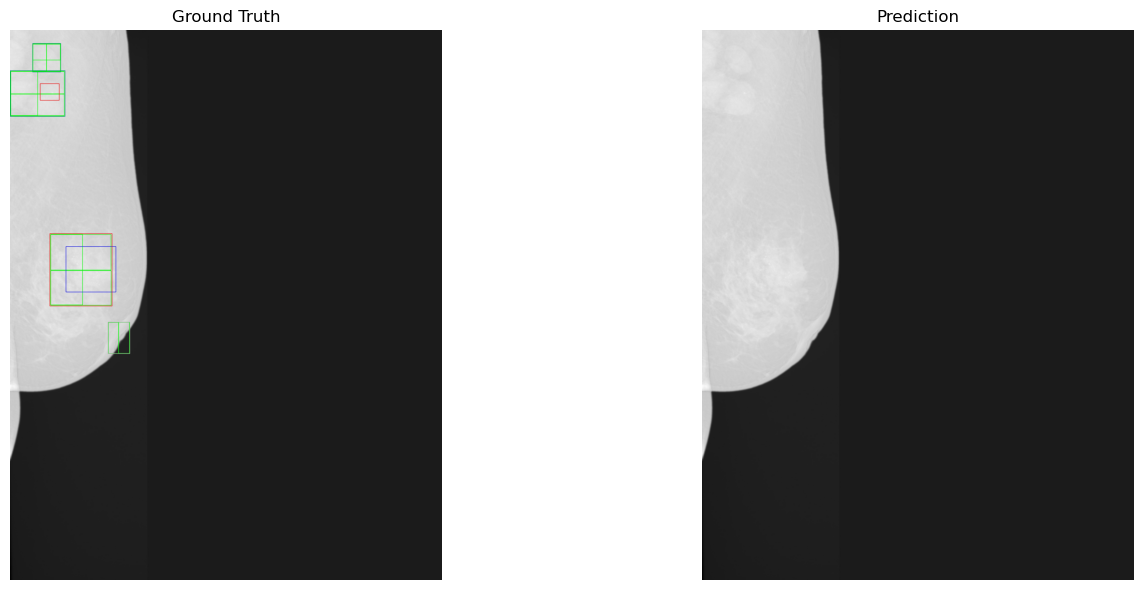

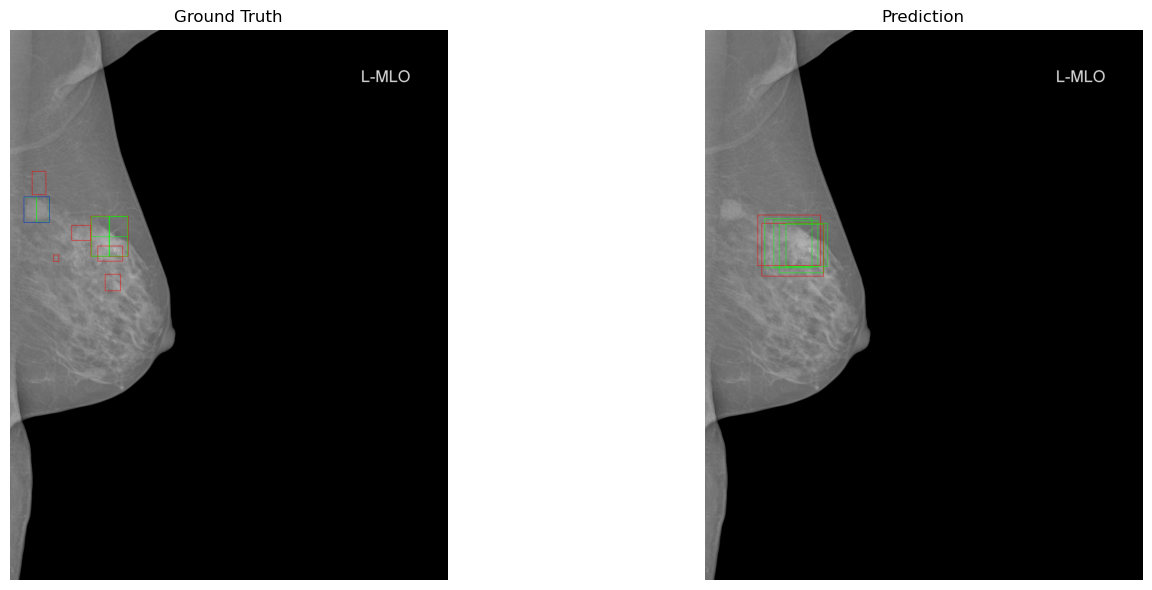

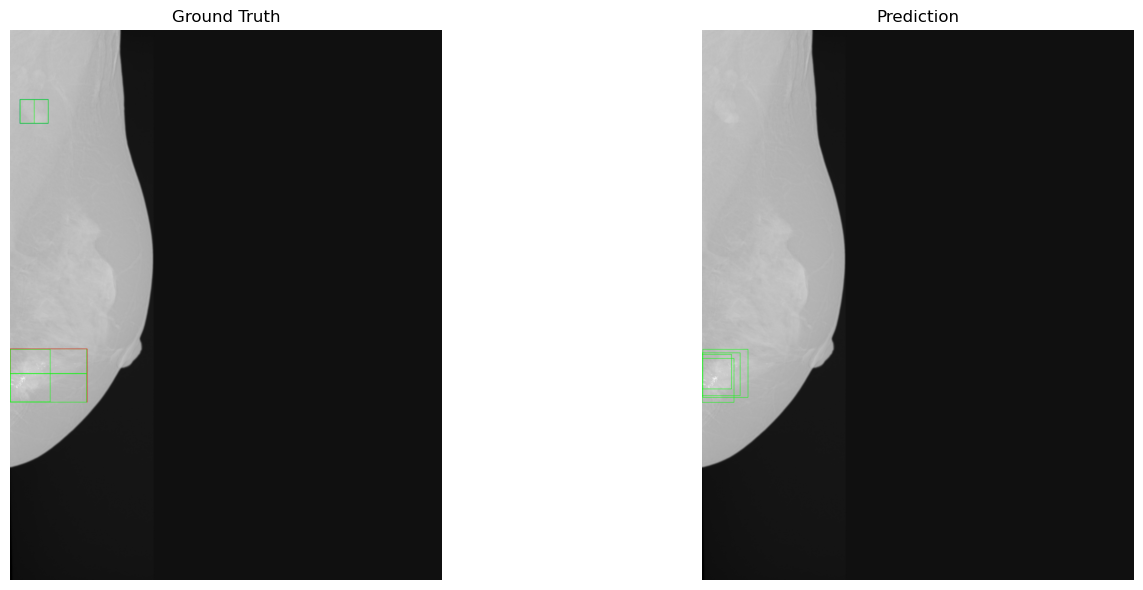

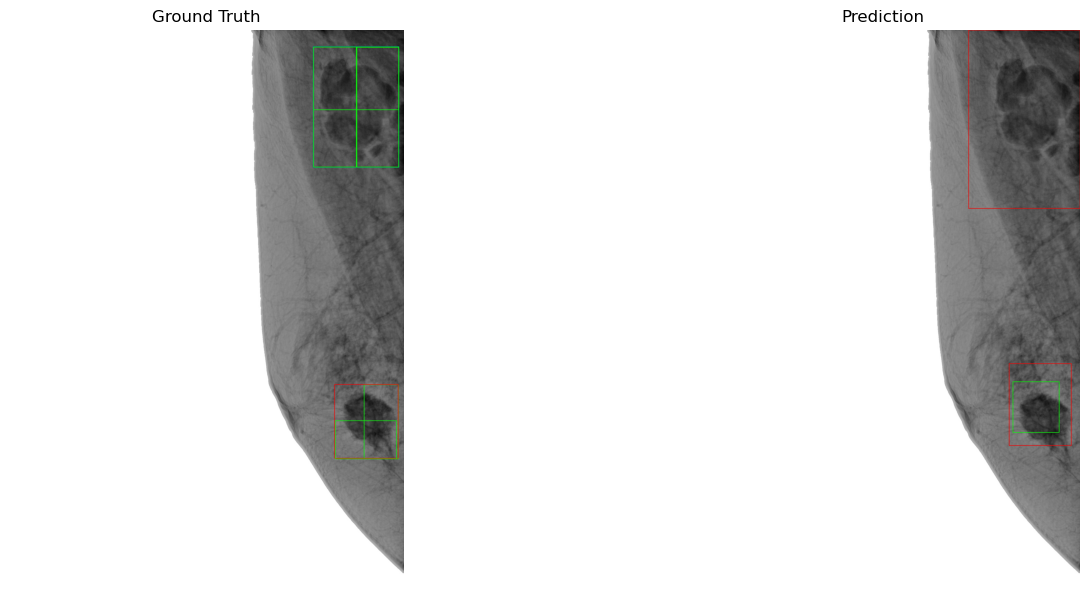

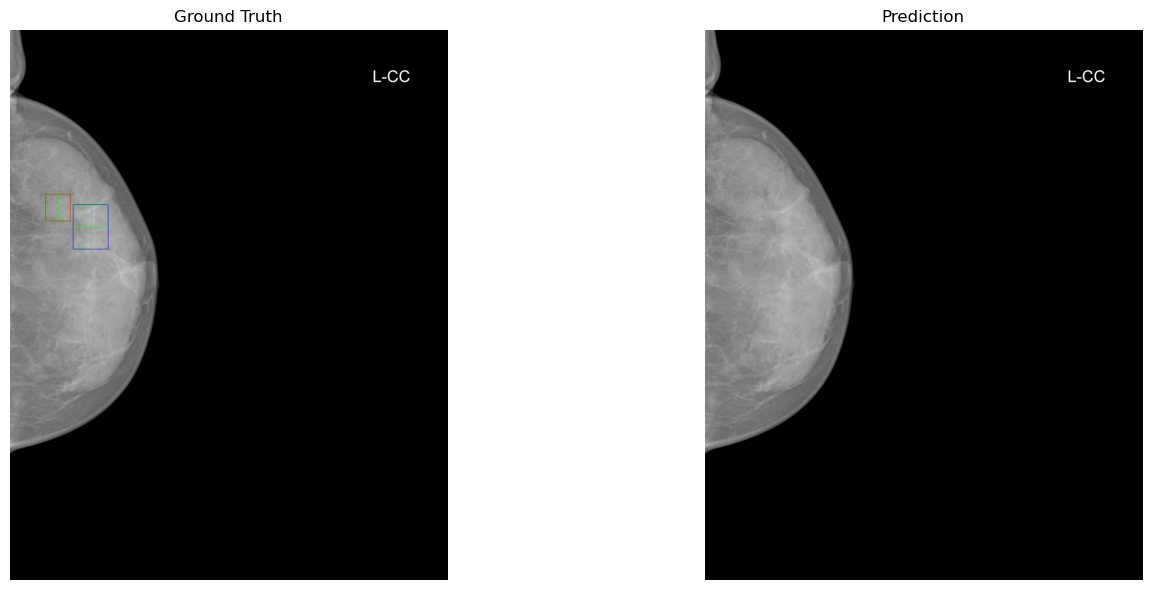

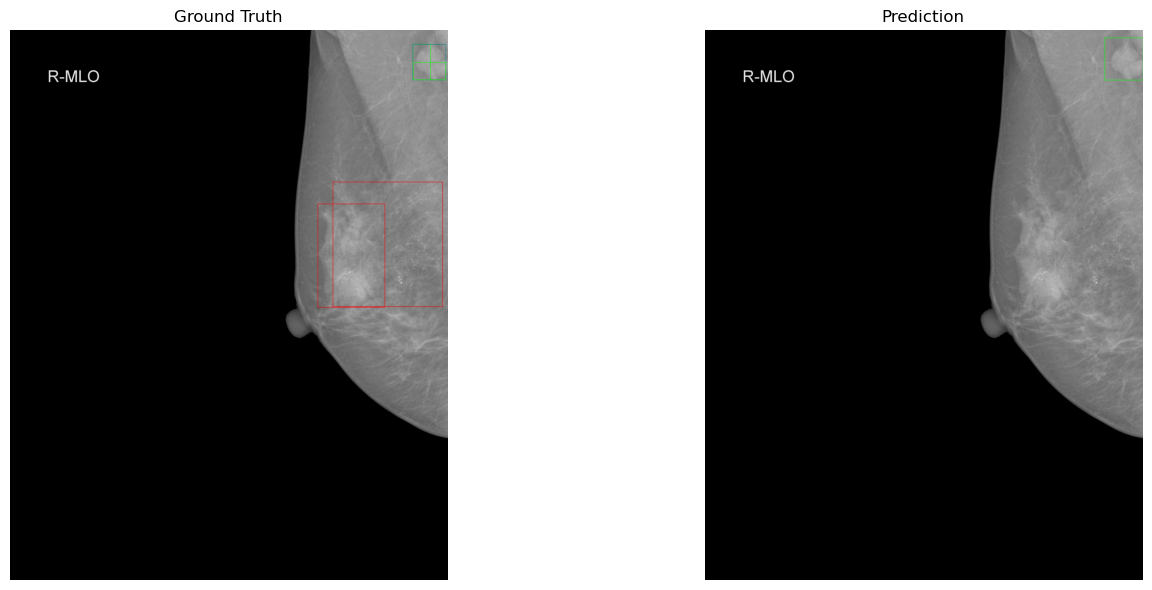

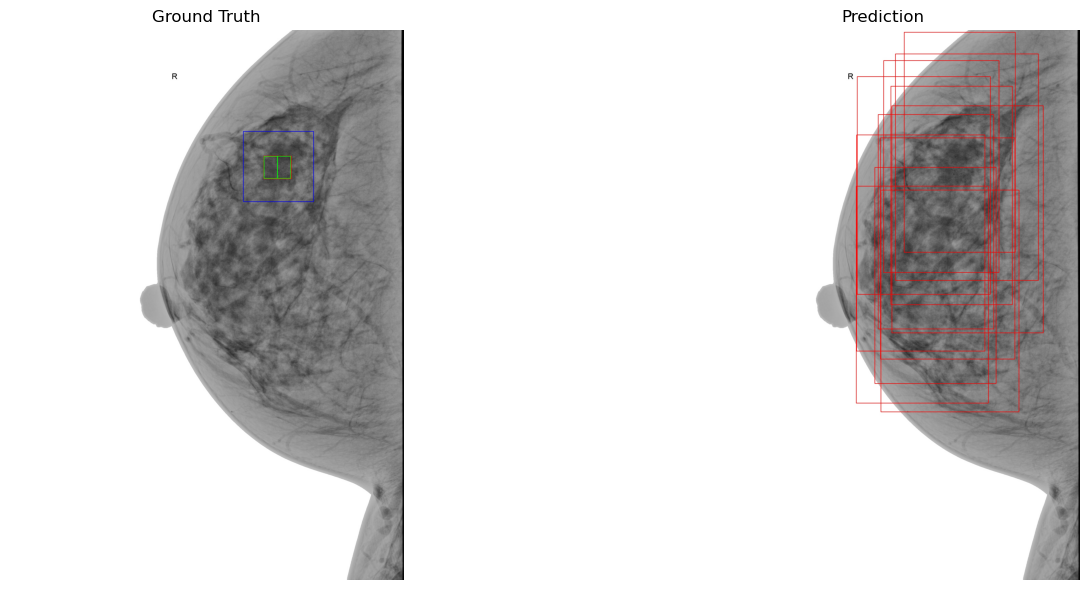

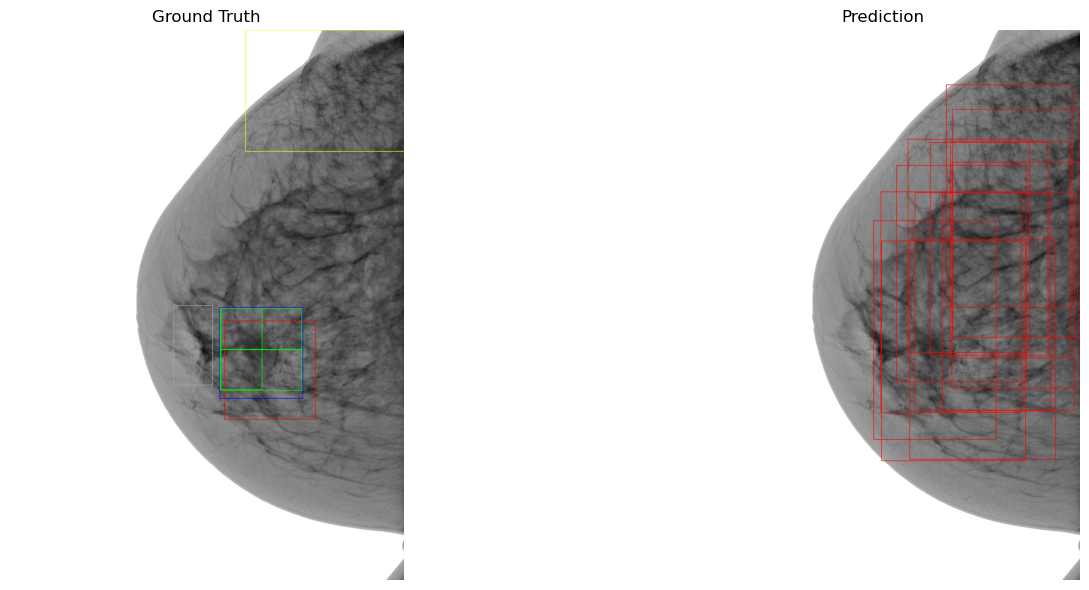

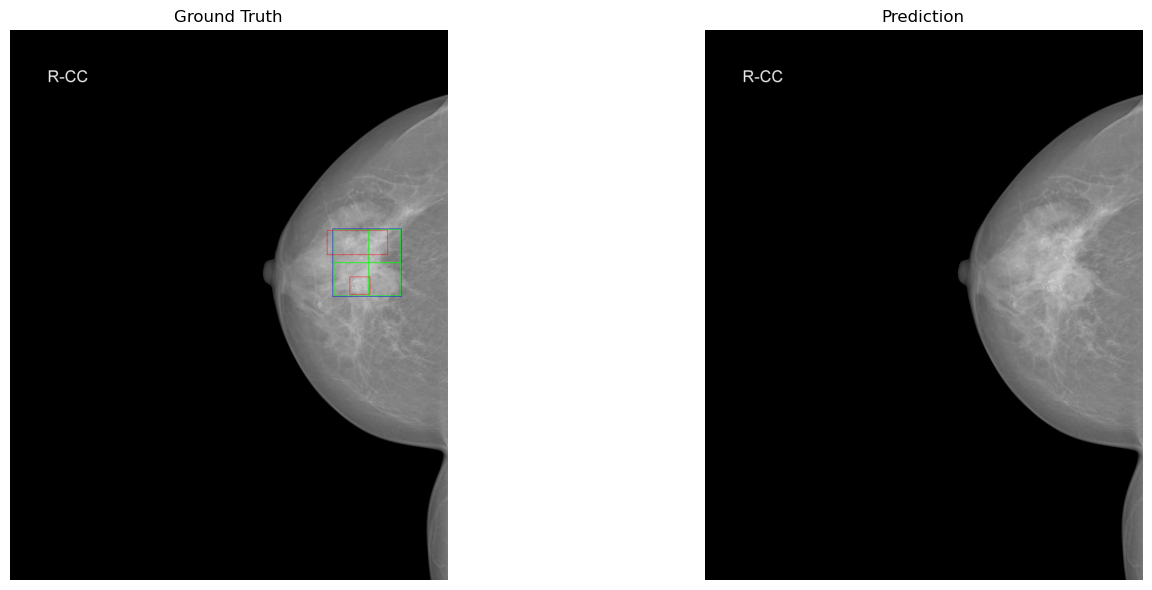

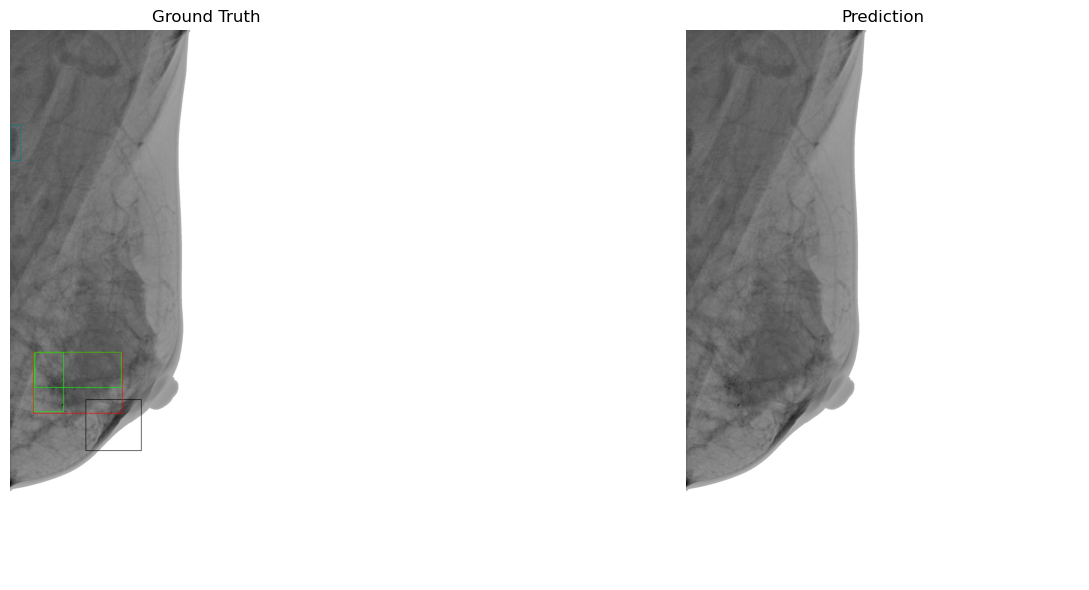

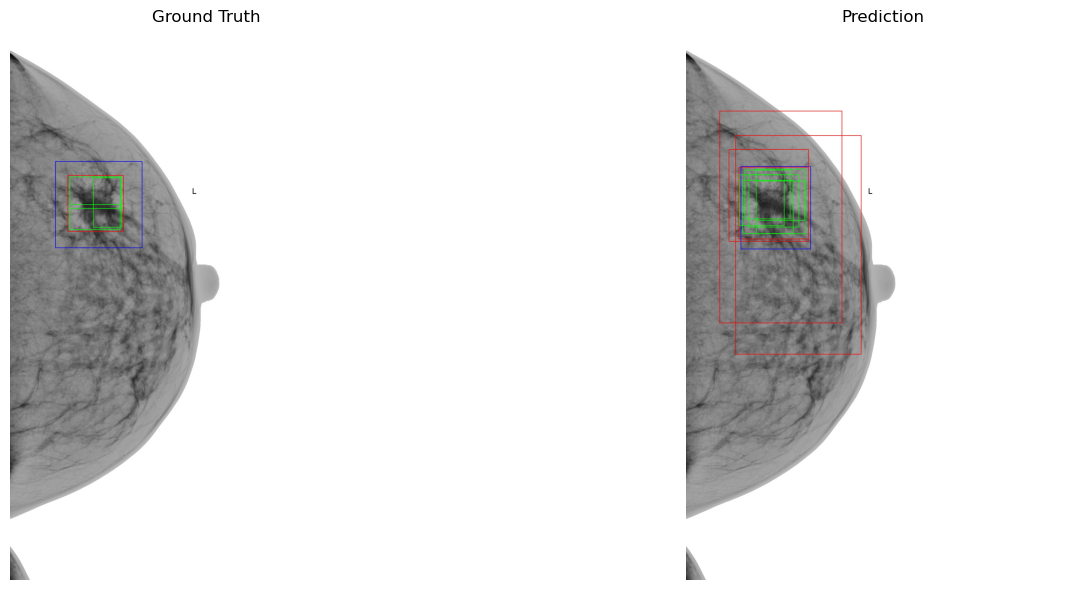

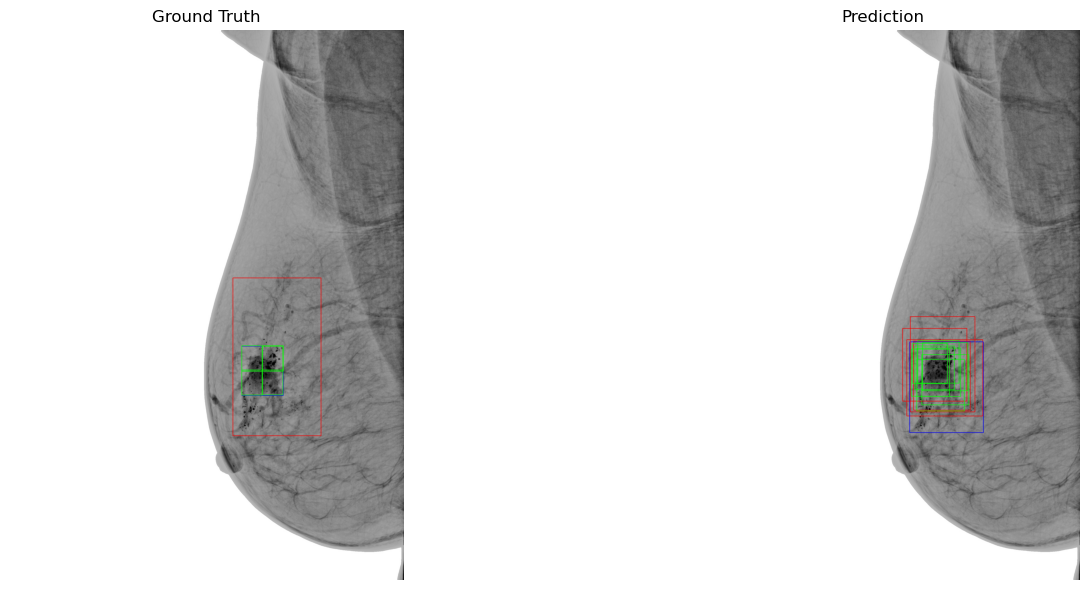

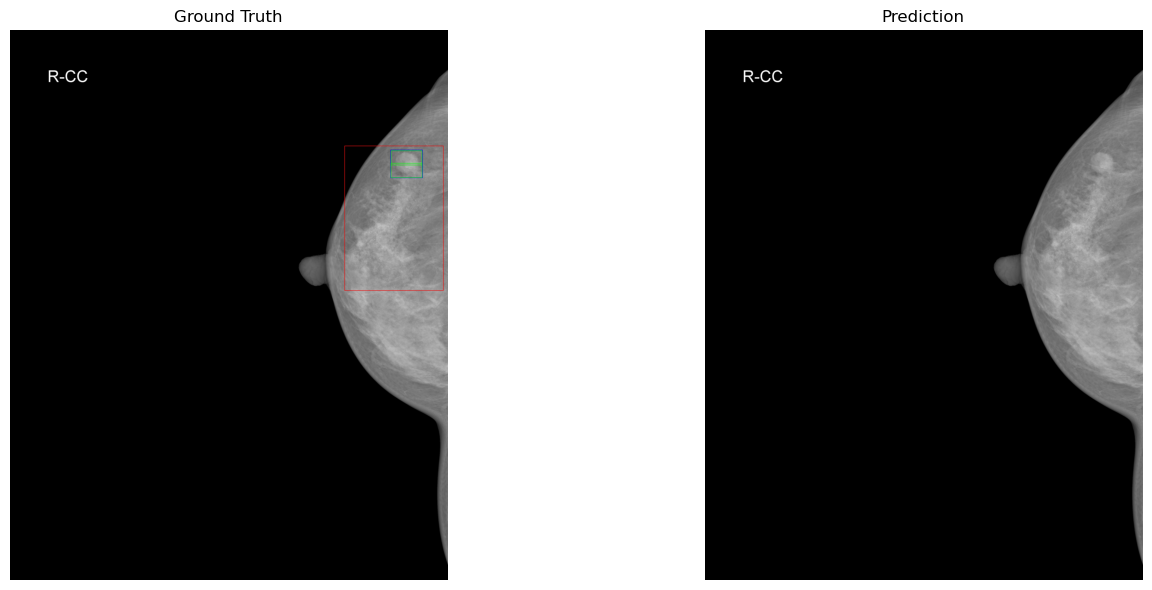

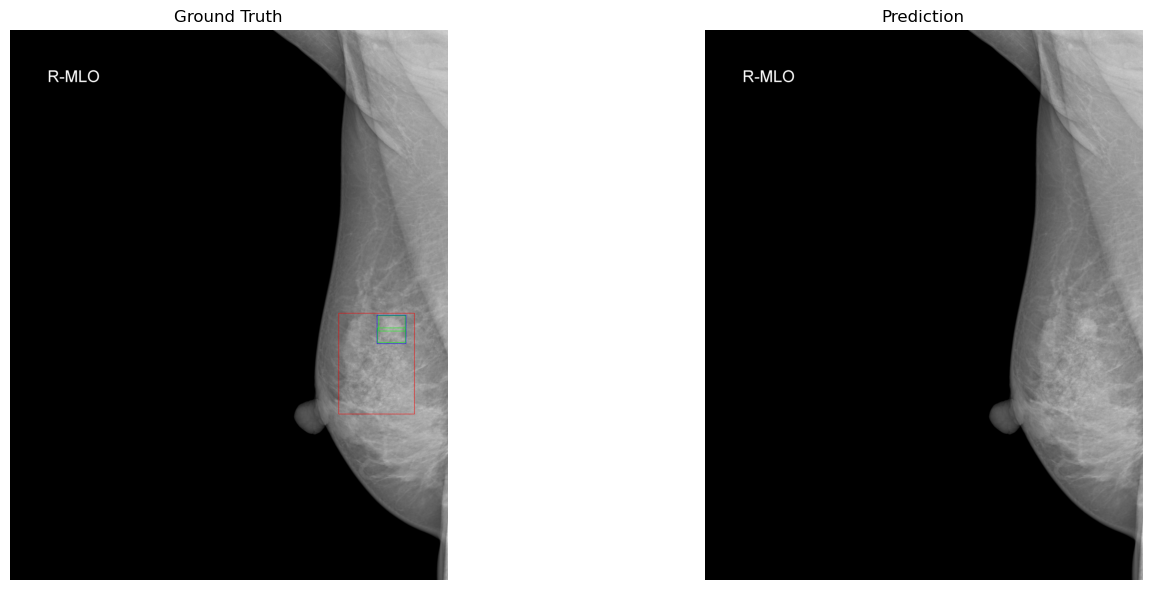

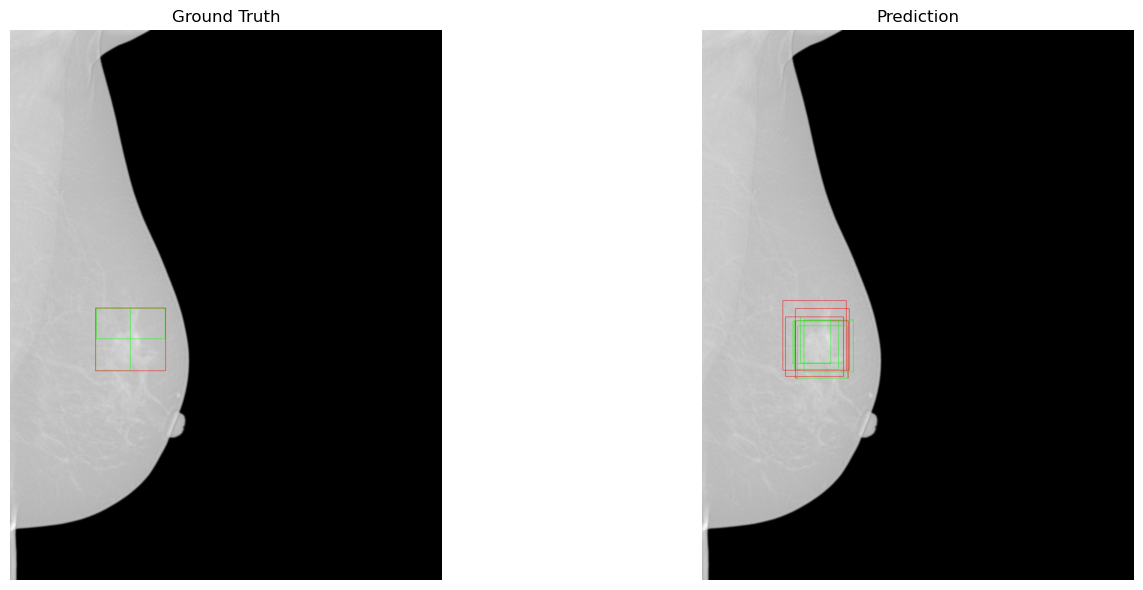

In [18]:
%matplotlib inline

output_labels_file_names = sorted(os.listdir(output_labels_dir))
output_pred_file_names = sorted(os.listdir(output_pred_dir))

for label_file, pred_file in zip(output_labels_file_names, output_pred_file_names):
    label_img = cv2.imread(os.path.join(output_labels_dir, label_file))
    pred_img = cv2.imread(os.path.join(output_pred_dir, pred_file))
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    axs[0].imshow(cv2.cvtColor(label_img, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Ground Truth')
    axs[0].axis('off')
    axs[1].imshow(cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Prediction')
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()